### Model 3: Text Clustering 

- To create a number of text clusters based on ['keywords'] (expand to more texts later). 
- Use keywords to predict clusters -> provide list of recommendation from the clusters
- GUI: through the clusters, create a set of short quiz users would take to pick the words and then provide the recommendation.

In [139]:
import pandas as pd

pd.set_option("display.max_columns", 85)
pd.set_option("display.max_rows", 85)
df = pd.read_csv('../../edit_data/cleaned_data/movies_main.csv')  
df.head()

## Data will contain all movie_meta data + keywords. 

,Id,Original_Title,Original_Language,Spoken_Languages,Budget,Revenue,Runtime,Release_Date,Production_Companies,Production_Countries,imdb_id,Popularity,Vote_Average,Vote_Count,Belongs_To_Collection,Tagline,Overview,Genres,Keywords
0,862,Toy Story,en,"[{'iso_639_1': 'en', 'name': 'English'}]",30000000.0,373554033.0,81.0,1995-10-30,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",tt0114709,21.946943,7.7,5415.0,"{'id': 10194, 'name': 'Toy Story Collection', ...",NaN,"Led by Woody, Andy's toys live happily in his ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,Jumanji,en,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",65000000.0,262797249.0,104.0,1995-12-15,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",tt0113497,17.015539,6.9,2413.0,NaN,Roll the dice and unleash the excitement!,When siblings Judy and Peter discover an encha...,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,Grumpier Old Men,en,"[{'iso_639_1': 'en', 'name': 'English'}]",0.0,0.0,101.0,1995-12-22,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",tt0113228,11.712900,6.5,92.0,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",Still Yelling. Still Fighting. Still Ready for...,A family wedding reignites the ancient feud be...,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,Waiting to Exhale,en,"[{'iso_639_1': 'en', 'name': 'English'}]",16000000.0,81452156.0,127.0,1995-12-22,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",tt0114885,3.859495,6.1,34.0,NaN,Friends are the people who let you be yourself...,"Cheated on, mistreated and stepped on, the wom...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,Father of the Bride Part II,en,"[{'iso_639_1': 'en', 'name': 'English'}]",0.0,76578911.0,106.0,1995-02-10,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",tt0113041,8.387519,5.7,173.0,"{'id': 96871, 'name': 'Father of the Bride Col...",Just When His World Is Back To Normal... He's ...,Just when George Banks has recovered from his ...,"[{'id': 35, 'name': 'Comedy'}]","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


Parse ['keywords']

In [10]:
### DO NOT RUN 
# This is a code to parse 1 column at a time
import ast
import numpy as np

# Function to parse the string and extract 'name'
def extract_names(data_string):
    if pd.isna(data_string):
        return np.nan
    try:
        # Safely evaluate the string to a Python object
        data_object = ast.literal_eval(data_string)
        if isinstance(data_object, list):
            # Extract 'name' from each dictionary in the list
            names = [item['name'] for item in data_object]
            return names
        elif isinstance(data_object, dict):
            # Extract 'name' from the dictionary
            return [data_object.get('name', np.nan)]
    except (ValueError, SyntaxError):
        return np.nan
    
    
df['Keywords_Parse'] = df['Keywords'].apply(extract_names)

In [157]:
###  parse and extract "name" in Keywords and then join them as one single string before text extraction
###  new series ['Joined_String]

# Function to process each row
def extract_and_join_names(row):
    try:
        # Convert the string representation of the list to an actual list
        list_of_dicts = ast.literal_eval(row)
        # Extract the 'name' from each dictionary and join them with a space
        return " ".join([d['name'] for d in list_of_dicts])
    except (ValueError, SyntaxError):
        return np.nan

# Apply the function to each row in your data
df['Joined_Strings'] = [extract_and_join_names(row) for row in df['Keywords']]
df['Joined_Strings'].head()

0    jealousy toy boy friendship friends rivalry bo...
1    board game disappearance based on children's b...
2     fishing best friend duringcreditsstinger old men
3    based on novel interracial relationship single...
4    baby midlife crisis confidence aging daughter ...
Name: Joined_Strings, dtype: object

In [168]:
# Step 3: Data preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# convert dtype to unicode
# use only joined strings in ['keywords'] now, can potentially add other data 
documents = df['Joined_Strings'].values.astype("U")

vectorizer = TfidfVectorizer(stop_words='english')
features = vectorizer.fit_transform(documents) #this is X


In [142]:
# we use K=7 based on Elbow test analysed
# TODO: calculate the SSE and plot it against K to get the elbow number of K.

k = 7
model = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
model.fit(features)

KMeans(max_iter=100, n_clusters=7, n_init=1)

In [143]:
# add/update cluster number after the fit. 
df['cluster'] = model.labels_
df.head()

,Id,Original_Title,Original_Language,Spoken_Languages,Budget,Revenue,Runtime,Release_Date,Production_Companies,Production_Countries,imdb_id,Popularity,Vote_Average,Vote_Count,Belongs_To_Collection,Tagline,Overview,Genres,Keywords,Joined_Strings,cluster
0,862,Toy Story,en,"[{'iso_639_1': 'en', 'name': 'English'}]",30000000.0,373554033.0,81.0,1995-10-30,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",tt0114709,21.946943,7.7,5415.0,"{'id': 10194, 'name': 'Toy Story Collection', ...",NaN,"Led by Woody, Andy's toys live happily in his ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",jealousy toy boy friendship friends rivalry bo...,1
1,8844,Jumanji,en,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",65000000.0,262797249.0,104.0,1995-12-15,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",tt0113497,17.015539,6.9,2413.0,NaN,Roll the dice and unleash the excitement!,When siblings Judy and Peter discover an encha...,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[{'id': 10090, 'name': 'board game'}, {'id': 1...",board game disappearance based on children's b...,2
2,15602,Grumpier Old Men,en,"[{'iso_639_1': 'en', 'name': 'English'}]",0.0,0.0,101.0,1995-12-22,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",tt0113228,11.712900,6.5,92.0,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",Still Yelling. Still Fighting. Still Ready for...,A family wedding reignites the ancient feud be...,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392...",fishing best friend duringcreditsstinger old men,1
3,31357,Waiting to Exhale,en,"[{'iso_639_1': 'en', 'name': 'English'}]",16000000.0,81452156.0,127.0,1995-12-22,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",tt0114885,3.859495,6.1,34.0,NaN,Friends are the people who let you be yourself...,"Cheated on, mistreated and stepped on, the wom...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'id': 818, 'name': 'based on novel'}, {'id':...",based on novel interracial relationship single...,0
4,11862,Father of the Bride Part II,en,"[{'iso_639_1': 'en', 'name': 'English'}]",0.0,76578911.0,106.0,1995-02-10,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",tt0113041,8.387519,5.7,173.0,"{'id': 96871, 'name': 'Father of the Bride Col...",Just When His World Is Back To Normal... He's ...,Just when George Banks has recovered from his ...,"[{'id': 35, 'name': 'Comedy'}]","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...",baby midlife crisis confidence aging daughter ...,0


In [144]:
print("Cluster centroids: \n")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(k):
    print("Cluster %d:" % i)
    for j in order_centroids[i, :10]: #print out 10 feature terms of each cluster
        print (' %s' % terms[j])
    print('------------')

Cluster centroids: 

Cluster 0:
 relationship
 brother
 father
 sister
 son
 daughter
 mother
 husband
 gay
 woman
------------
Cluster 1:
 film
 independent
 musical
 comedy
 based
 murder
 war
 love
 woman
 nudity
------------
Cluster 2:
 children
 book
 based
 child
 woman
 director
 cartoon
 ghost
 novel
 family
------------
Cluster 3:
 director
 woman
 independent
 film
 biography
 lesbian
 musical
 suspense
 comedy
 holiday
------------
Cluster 4:
 dinosaur
 prehistoric
 rex
 tyrannosaurus
 creature
 time
 travel
 island
 relationships
 3d
------------
Cluster 5:
 hockey
 ice
 sport
 coach
 player
 team
 biography
 sports
 water
 woman
------------
Cluster 6:
 martial
 arts
 kung
 fu
 shaolin
 revenge
 mixed
 sword
 fight
 blood
------------


Check Number of Cluster (K) with Elbow Method:

Fitting for 5 clusters
Fitting for 6 clusters
Fitting for 7 clusters
Fitting for 8 clusters
Fitting for 9 clusters
Fitting for 10 clusters
Fitting for 11 clusters
Fitting for 12 clusters
Fitting for 13 clusters
Fitting for 14 clusters
Fitting for 15 clusters
Fitting for 16 clusters
Fitting for 17 clusters
Fitting for 18 clusters
Fitting for 19 clusters


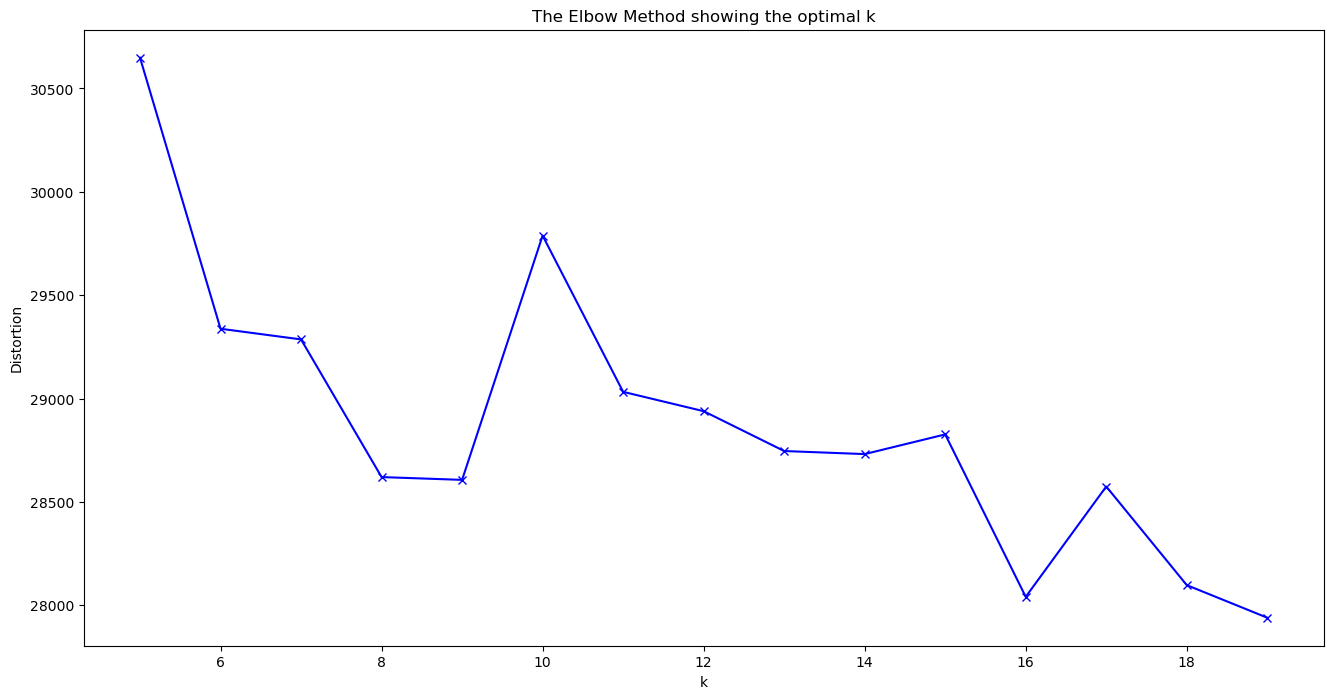

In [145]:
import matplotlib.pyplot as plt
from sklearn import metrics

distortions = []
ch_index = []
K = range(5,20)
for k in K:
    print("Fitting for " + str(k) + " clusters")
    kmeanModel = KMeans(n_clusters = k, init='k-means++', max_iter = 100, n_init = 1)
    kmeanModel.fit(features)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


#### Optimal k Value:
Optimal k: The elbow point seems to occur at k=8. This is where the distortion sees a significant drop, and the curve begins to flatten out afterward.


#### Create KNN Classifier model
- X = features (based on keywords)
- y = cluster

In [146]:
## Create the Training and Test set
#  plotting a scatter matrix
#  75 (training)/25 (test) is the default for train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X = features #this is the vectorized text from keywords
y = df['cluster']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [107]:
# Drop one line of movie that has NaN Keywords in Cluster 0.
df = df.loc[~df['Joined_Strings'].isna() == True].copy()

In [147]:
## Remove rows with missing data
filt = (df['Keywords']=="[]")
df = df.loc[~filt]

,Id,Original_Title,Original_Language,Spoken_Languages,Budget,Revenue,Runtime,Release_Date,Production_Companies,Production_Countries,imdb_id,Popularity,Vote_Average,Vote_Count,Belongs_To_Collection,Tagline,Overview,Genres,Keywords,Joined_Strings,cluster
0,862,Toy Story,en,"[{'iso_639_1': 'en', 'name': 'English'}]",30000000.0,373554033.0,81.0,1995-10-30,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",tt0114709,21.946943,7.7,5415.0,"{'id': 10194, 'name': 'Toy Story Collection', ...",NaN,"Led by Woody, Andy's toys live happily in his ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",jealousy toy boy friendship friends rivalry bo...,1
1,8844,Jumanji,en,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",65000000.0,262797249.0,104.0,1995-12-15,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",tt0113497,17.015539,6.9,2413.0,NaN,Roll the dice and unleash the excitement!,When siblings Judy and Peter discover an encha...,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[{'id': 10090, 'name': 'board game'}, {'id': 1...",board game disappearance based on children's b...,2
2,15602,Grumpier Old Men,en,"[{'iso_639_1': 'en', 'name': 'English'}]",0.0,0.0,101.0,1995-12-22,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",tt0113228,11.712900,6.5,92.0,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",Still Yelling. Still Fighting. Still Ready for...,A family wedding reignites the ancient feud be...,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392...",fishing best friend duringcreditsstinger old men,1
3,31357,Waiting to Exhale,en,"[{'iso_639_1': 'en', 'name': 'English'}]",16000000.0,81452156.0,127.0,1995-12-22,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",tt0114885,3.859495,6.1,34.0,NaN,Friends are the people who let you be yourself...,"Cheated on, mistreated and stepped on, the wom...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'id': 818, 'name': 'based on novel'}, {'id':...",based on novel interracial relationship single...,0
4,11862,Father of the Bride Part II,en,"[{'iso_639_1': 'en', 'name': 'English'}]",0.0,76578911.0,106.0,1995-02-10,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",tt0113041,8.387519,5.7,173.0,"{'id': 96871, 'name': 'Father of the Bride Col...",Just When His World Is Back To Normal... He's ...,Just when George Banks has recovered from his ...,"[{'id': 35, 'name': 'Comedy'}]","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...",baby midlife crisis confidence aging daughter ...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45420,430834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'id': 187056, 'name': 'woman director'}]",woman director,3
45423,394185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'id': 206441, 'name': 'pro wrestling'}]",pro wrestling,1
45425,355193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'id': 1812, 'name': 'fbi'}]",fbi,1
45431,87229,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'id': 5746, 'name': 'iceland'}, {'id': 23175...",iceland coming home,1


In [148]:
print(X_train.shape)  # Should output (45433, n_features) where n_features is the number of features.
print(y_train.shape)  # Should output (45433,) if it's a 1D array.

(34074, 12597)
(34074,)


In [149]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [150]:
knn.score(X_test, y_test)

0.9629368782463245

Predict

In [194]:
# test data 
new_keywords = ['relationship', 'murder war', 'children cartoon', 'dinosaur','hockey', 'kung fu']
X_new = vectorizer.transform(new_keywords)
predicted_cluster = knn.predict(X_new)

print("Predicted Clusters for new keywords:", predicted_cluster)


Predicted Clusters for new keywords: [0 1 2 4 5 6]
